In [26]:
import findspark
findspark.init()
from pyspark.sql import SparkSession

spark = SparkSession.builder \
        .master('local[*]') \
        .appName('Basics') \
        .getOrCreate()

print(spark.version)

3.5.4


In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier, CatBoostRegressor

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Assign home directory
home_dir = 'C:/Users/gyalm/OneDrive/Desktop/btl_model'

In [28]:
# Define functions
# Import additional packages
import datetime
import csv
import yaml
import io
import dill as pickle
import os

def get_datetime():
    """Returns datetime for filename use.

    :return: datetime
    :rtype: string
    """
    stamp = datetime.datetime.now()
    datetime_name = f"{stamp.year:04}{stamp.month:02}{stamp.day:02}_{stamp.hour:02}{stamp.minute:02}"
    print(datetime_name)
    return datetime_name

print('Functions ready!')

Functions ready!


In [32]:
# Read CSV
df = spark.read.csv(f"{home_dir}/data/skincare_transactions.csv", inferSchema=True, header=True)
df.show(10)
df.createOrReplaceTempView("df_view")

+-------+---+------+--------+------+--------------+----------------+------------+-----------+-------------+-----------+--------+----------+--------------------+-------------+
|user_id|age| price|quantity|rating|transaction_id|transaction_date|product_code|category_id|category_name|temperature|humidity|wind_speed|        weather_list|realfeel_list|
+-------+---+------+--------+------+--------------+----------------+------------+-----------+-------------+-----------+--------+----------+--------------------+-------------+
|   4515| 63|185.22|       3|   4.0|        728380|      2023-07-03|      SK2800|          1|    CLEANSERS|       24.7|    48.6|       2.6|Mostly cloudy wit...|         22.7|
|   2897| 60|149.97|       1|   3.7|        914925|      2024-12-25|      SK6868|          8|   SUNSCREENS|       31.4|    79.7|       7.7|        Partly sunny|         30.3|
|   4473| 32|121.42|       4|   3.3|        869743|      2023-04-04|      SK4406|          8|   SUNSCREENS|       35.4|    36

In [33]:
# Check partition dates
spark.sql('''
SELECT
   MIN(transaction_date)
  ,MAX(transaction_date)
FROM
  df_view
''').show()

+---------------------+---------------------+
|min(transaction_date)|max(transaction_date)|
+---------------------+---------------------+
|           2023-01-01|           2024-12-31|
+---------------------+---------------------+



In [7]:
# Count no. of product types under each skincare category
spark.sql('''
SELECT 
  category_name, 
  COUNT(product_code) AS product_count
FROM 
  df_view
GROUP BY 
  category_name
ORDER BY 
  product_count DESC
''').show()

+-------------+-------------+
|category_name|product_count|
+-------------+-------------+
|       TONERS|         2289|
|      EYECARE|         2239|
|    ANTIAGING|         2237|
|   SUNSCREENS|         2236|
|       SERUMS|         2236|
|    CLEANSERS|         2216|
|   EXFOLIANTS|         2195|
|        MASKS|         2183|
| MOISTURIZERS|         2169|
+-------------+-------------+



In [69]:
# Calculate total revenue of each skincare category to find low performing category
spark.sql('''
SELECT 
  category_name, 
  COUNT(product_code) AS product_count,
  ROUND(SUM(price * quantity), 2) AS total_revenue
FROM 
  df_view
GROUP BY 
  category_name
ORDER BY 
  total_revenue DESC
''').show()

+-------------+-------------+-------------+
|category_name|product_count|total_revenue|
+-------------+-------------+-------------+
|       TONERS|         2289|     721806.5|
|       SERUMS|         2236|    690544.72|
|   EXFOLIANTS|         2195|    684883.76|
| MOISTURIZERS|         2169|    683489.89|
|   SUNSCREENS|         2236|    676396.53|
|        MASKS|         2183|    673321.62|
|    ANTIAGING|         2237|    670187.22|
|      EYECARE|         2239|    666658.57|
|    CLEANSERS|         2216|    663146.35|
+-------------+-------------+-------------+



In [70]:
# Count distinct low-performing product in middle skincare category (SERUMS)
spark.sql('''
SELECT 
  category_name, 
  COUNT(DISTINCT product_code) AS distinct_product_count
FROM 
  df_view
WHERE 
  category_name = 'SERUMS'
GROUP BY 
  category_name
''').show()

+-------------+----------------------+
|category_name|distinct_product_count|
+-------------+----------------------+
|       SERUMS|                    30|
+-------------+----------------------+



In [71]:
# Calculate and rank sales revenue of products from low-performing SERUMS category
spark.sql('''
SELECT 
  product_code,
  category_name,
  ROUND(SUM(price * quantity), 2) AS total_revenue
FROM 
  df_view
WHERE 
  category_name = 'SERUMS'
GROUP BY 
  product_code, category_name
ORDER BY 
  total_revenue DESC
''').show()

+------------+-------------+-------------+
|product_code|category_name|total_revenue|
+------------+-------------+-------------+
|      SK9029|       SERUMS|     28241.36|
|      SK9803|       SERUMS|     26786.49|
|      SK7465|       SERUMS|     26651.46|
|      SK6490|       SERUMS|      25956.7|
|      SK4507|       SERUMS|     25157.49|
|      SK2615|       SERUMS|     24619.95|
|      SK7914|       SERUMS|     24524.39|
|      SK1041|       SERUMS|     24180.52|
|      SK2495|       SERUMS|     23668.68|
|      SK4514|       SERUMS|      23569.6|
|      SK3736|       SERUMS|     23429.81|
|      SK4128|       SERUMS|     23231.75|
|      SK6203|       SERUMS|     23202.02|
|      SK4131|       SERUMS|     22943.27|
|      SK9642|       SERUMS|     22818.09|
|      SK4382|       SERUMS|     22672.66|
|      SK6584|       SERUMS|     22448.19|
|      SK6551|       SERUMS|     22411.56|
|      SK2400|       SERUMS|     22286.16|
|      SK6121|       SERUMS|     22117.12|
+----------

In [72]:
# Identify which product_code revenue is closest to median revenue
spark.sql('''
WITH serum_revenue AS (
  SELECT 
    product_code,
    SUM(price * quantity) AS total_product_revenue
  FROM 
    df_view
  WHERE 
    category_name = 'SERUMS'
  GROUP BY 
    product_code
),
median_value AS (
  SELECT 
    PERCENTILE_APPROX(total_product_revenue, 0.5) AS median_serum_revenue
  FROM 
    serum_revenue
)
SELECT 
  s.product_code,
  s.total_product_revenue,
  m.median_serum_revenue,
  ABS(s.total_product_revenue - m.median_serum_revenue) AS difference
FROM 
  serum_revenue s
CROSS JOIN 
  median_value m
ORDER BY 
  difference ASC
LIMIT 1
''').show()

+------------+---------------------+--------------------+----------+
|product_code|total_product_revenue|median_serum_revenue|difference|
+------------+---------------------+--------------------+----------+
|      SK4382|   22672.660000000007|  22672.660000000007|       0.0|
+------------+---------------------+--------------------+----------+



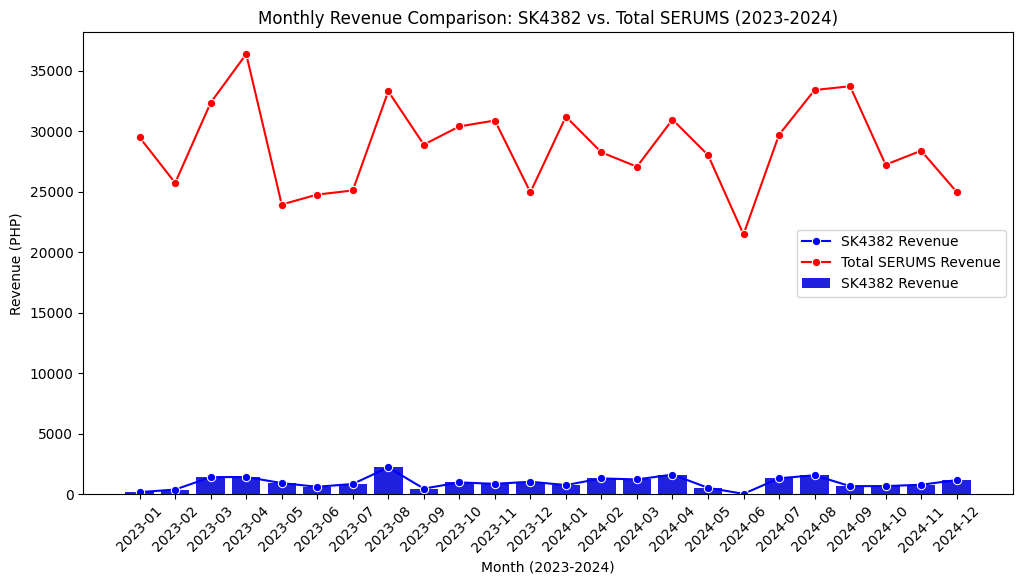

In [82]:
# Monthly Revenue Comparison: Product SK4382 vs. Total SERUMS (2023)

df = spark.sql('''
WITH serum_monthly_revenue AS (
  SELECT 
    DATE_FORMAT(transaction_date, 'yyyy-MM') AS sale_date,
    SUM(price * quantity) AS total_serums_revenue
  FROM 
    df_view
  WHERE 
    category_name = 'SERUMS' 
    AND transaction_date BETWEEN '2023-01-01' AND '2024-12-31'
  GROUP BY 
    DATE_FORMAT(transaction_date, 'yyyy-MM')
),
product_monthly_revenue AS (
  SELECT 
    DATE_FORMAT(transaction_date, 'yyyy-MM') AS sale_date,
    SUM(price * quantity) AS product_revenue
  FROM 
    df_view
  WHERE 
    category_name = 'SERUMS' 
    AND product_code = 'SK4382'
    AND transaction_date BETWEEN '2023-01-01' AND '2024-12-31'
  GROUP BY 
    DATE_FORMAT(transaction_date, 'yyyy-MM')
)
SELECT 
  p.sale_date,
  p.product_revenue,
  s.total_serums_revenue
FROM 
  product_monthly_revenue p
JOIN 
  serum_monthly_revenue s
ON 
  p.sale_date = s.sale_date
ORDER BY 
  p.sale_date
''')

df_pandas = df.toPandas()

plt.figure(figsize=(12, 6))

sns.barplot(
    x='sale_date', y='product_revenue', data=df_pandas, 
    color='blue', label='SK4382 Revenue'
)

sns.lineplot(
    x='sale_date', y='product_revenue', data=df_pandas, 
    color='blue', marker='o', label='SK4382 Revenue'
)

sns.lineplot(
    x='sale_date', y='total_serums_revenue', data=df_pandas, 
    color='red', marker='o', label='Total SERUMS Revenue'
)

plt.xticks(rotation=45)
plt.xlabel("Month (2023-2024)")
plt.ylabel("Revenue (PHP)")
plt.title("Monthly Revenue Comparison: SK4382 vs. Total SERUMS (2023-2024)")
plt.legend()
plt.show()

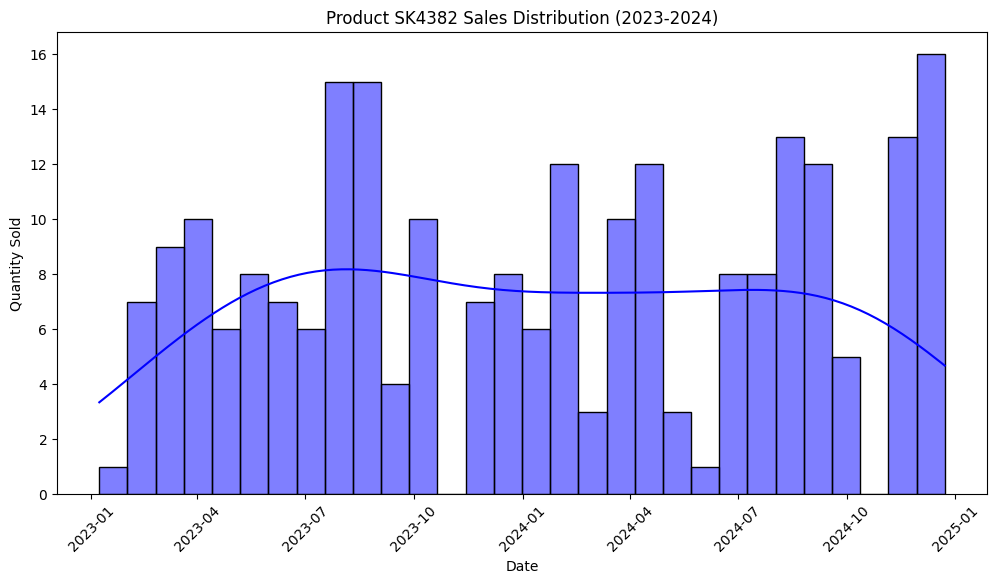

In [87]:
# Focus on product SK4382 sales distribution
df = spark.sql('''
WITH low_product_sales AS (
    SELECT 
        transaction_date AS sale_date,
        SUM(quantity) AS total_quantity
    FROM df_view
    WHERE 
        transaction_date BETWEEN '2023-01-01' AND '2024-12-31'
        AND product_code = 'SK4382'
    GROUP BY sale_date
)
SELECT 
    sale_date, 
    total_quantity
FROM low_product_sales
ORDER BY sale_date;
''')

df_pandas = df.toPandas()

df_pandas['sale_date'] = pd.to_datetime(df_pandas['sale_date'])

plt.figure(figsize=(12, 6))
sns.histplot(df_pandas, x='sale_date', weights='total_quantity', bins=30, kde=True, color='blue')

plt.xlabel("Date")
plt.ylabel("Quantity Sold")
plt.title("Product SK4382 Sales Distribution (2023-2024)")
plt.xticks(rotation=45)

plt.show()

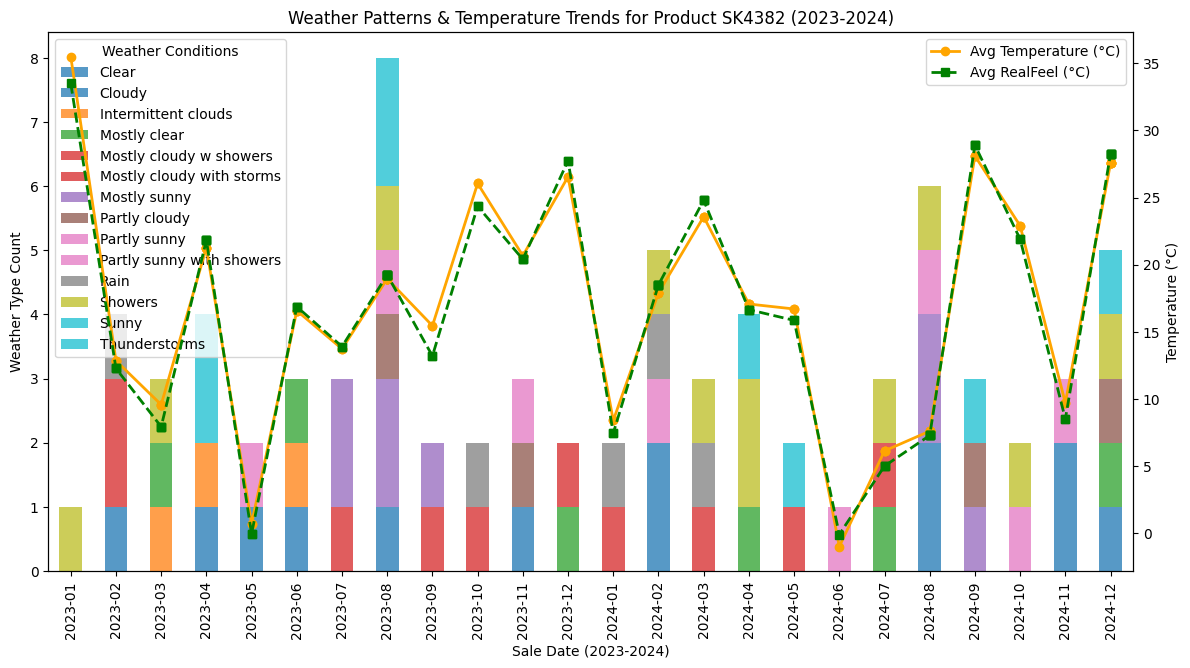

In [94]:
# Weather Patterns & Temperature Trends for Product SK4382 (2023-2024)
df = spark.sql('''
WITH monthly_sales AS (
    SELECT 
        DATE_TRUNC('month', transaction_date) AS sale_date,
        weather_list,
        CAST(temperature AS FLOAT) AS temperature,  -- FIXED COLUMN NAME
        CAST(realfeel_list AS FLOAT) AS realfeel_list
    FROM df_view
    WHERE product_code = 'SK4382'
        AND transaction_date BETWEEN '2023-01-01' AND '2024-12-31'
),

weather_count_per_month AS (
    SELECT 
        sale_date,
        weather_list,
        COUNT(*) AS weather_count
    FROM monthly_sales
    GROUP BY sale_date, weather_list
),

monthly_averages AS (
    SELECT 
        sale_date,
        ROUND(AVG(temperature), 2) AS avg_temperature,
        ROUND(AVG(realfeel_list), 2) AS avg_realfeel
    FROM monthly_sales
    GROUP BY sale_date
)

SELECT 
    wc.sale_date,
    wc.weather_list,
    wc.weather_count,
    ma.avg_temperature,
    ma.avg_realfeel
FROM weather_count_per_month wc
LEFT JOIN monthly_averages ma 
    ON wc.sale_date = ma.sale_date
ORDER BY wc.sale_date ASC
''')

df_pandas = df.toPandas()

df_pandas["sale_date"] = pd.to_datetime(df_pandas["sale_date"]).dt.strftime('%Y-%m')

weather_pivot = df_pandas.pivot(index="sale_date", columns="weather_list", values="weather_count").fillna(0)

fig, ax1 = plt.subplots(figsize=(14, 7))

weather_pivot.plot(kind="bar", stacked=True, colormap="tab10", ax=ax1, alpha=0.75)

ax2 = ax1.twinx()
ax2.plot(df_pandas["sale_date"], df_pandas["avg_temperature"], color="orange", marker="o", linestyle="-", linewidth=2, label="Avg Temperature (°C)")
ax2.plot(df_pandas["sale_date"], df_pandas["avg_realfeel"], color="green", marker="s", linestyle="--", linewidth=2, label="Avg RealFeel (°C)")

ax1.set_xlabel("Sale Date (2023-2024)")
ax1.set_ylabel("Weather Type Count")
ax2.set_ylabel("Temperature (°C)")
plt.title("Weather Patterns & Temperature Trends for Product SK4382 (2023-2024)")

plt.xticks(rotation=45)

ax1.legend(loc="upper left", title="Weather Conditions")
ax2.legend(loc="upper right")

plt.show()

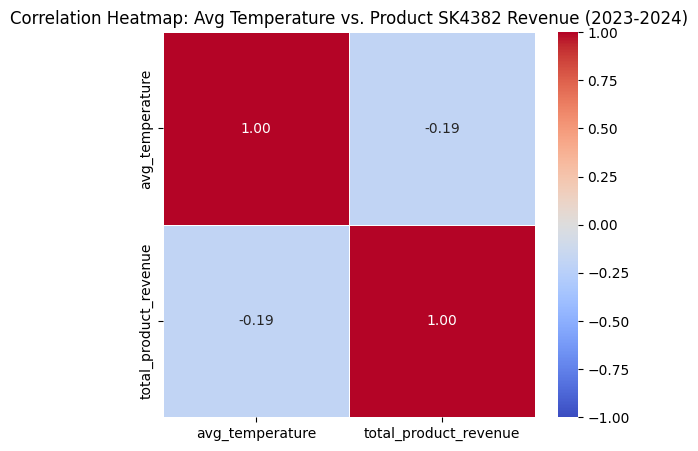

In [ ]:
# Compute correlation matrix for avg_temperature & total_product_revenue SK4382 
df = spark.sql("""
    WITH weather_sales AS (
        SELECT 
            weather_list,
            ROUND(AVG(temperature), 2) AS avg_temperature,
            ROUND(AVG(realfeel_list), 2) AS avg_realfeel,
            SUM(quantity * price) AS total_product_revenue
        FROM df_view
        WHERE product_code = 'SK4382'
            AND transaction_date BETWEEN '2023-01-01' AND '2024-12-31'
        GROUP BY weather_list
    )
    SELECT * FROM weather_sales
""").toPandas()

df = df.round(2)

correlation_matrix = df[['avg_temperature', 'total_product_revenue']].corr()

plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, vmin=-1, vmax=1)

plt.title("Correlation Heatmap: Avg Temperature vs. Product SK4382 Revenue (2023-2024)")
plt.show()

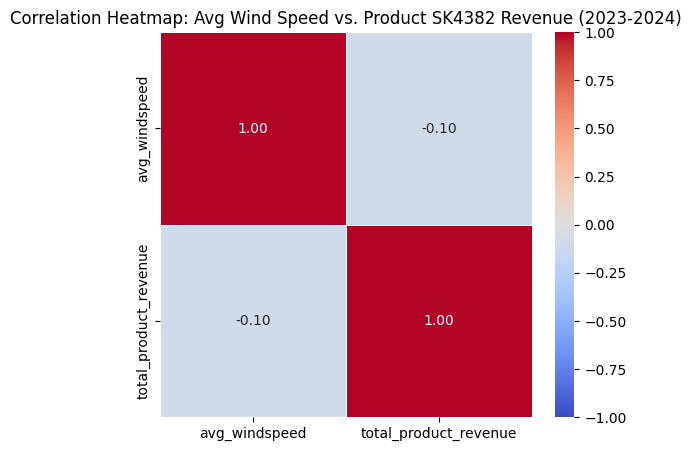

In [97]:
# Compute correlation matrix for avg_windspeed & total_product_revenue SK4382

df_weather = spark.sql("""
    WITH weather_sales AS (
        SELECT 
            weather_list,
            ROUND(AVG(wind_speed), 2) AS avg_windspeed,
            SUM(quantity * price) AS total_product_revenue
        FROM df_view
        WHERE product_code = 'SK4382'
            AND transaction_date BETWEEN '2023-01-01' AND '2024-12-31'
        GROUP BY weather_list
    )
    SELECT * FROM weather_sales
""").toPandas()

df_weather = df_weather.round(2)

correlation_matrix = df_weather[['avg_windspeed', 'total_product_revenue']].corr()

plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, vmin=-1, vmax=1)

plt.title("Correlation Heatmap: Avg Wind Speed vs. Product SK4382 Revenue (2023-2024)")
plt.show()


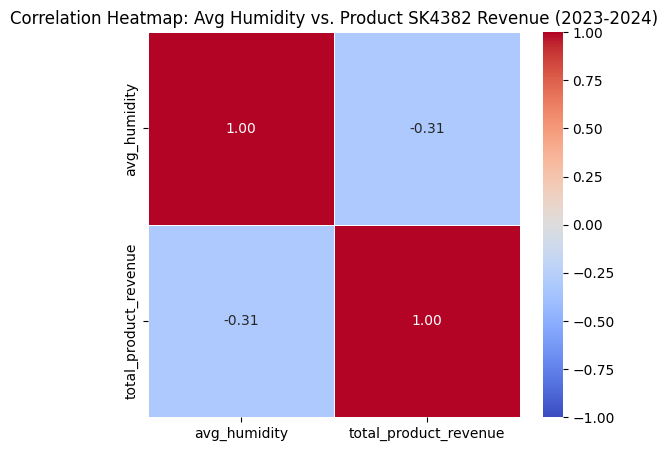

In [98]:
# Compute correlation matrix for avg_humidity & total_product_revenue SK4382

df_weather = spark.sql("""
    WITH weather_sales AS (
        SELECT 
            weather_list,
            ROUND(AVG(humidity), 2) AS avg_humidity,
            SUM(quantity * price) AS total_product_revenue
        FROM df_view
        WHERE product_code = 'SK4382'
            AND transaction_date BETWEEN '2023-01-01' AND '2024-12-31'
        GROUP BY weather_list
    )
    SELECT * FROM weather_sales
""").toPandas()

df_weather = df_weather.round(2)

correlation_matrix = df_weather[['avg_humidity', 'total_product_revenue']].corr()

plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, vmin=-1, vmax=1)

plt.title("Correlation Heatmap: Avg Humidity vs. Product SK4382 Revenue (2023-2024)")
plt.show()

**Comparison of Heatmaps:**

1. _Avg Humidity vs. Product SK4382 Revenue_
    - Correlation Coefficient: -0.31
    - Interpretation: A moderate negative correlation, suggesting that as humidity increases, product revenue tends to decrease.

2. _Avg Wind Speed vs. Product SK4382 Revenue_
    - Correlation Coefficient: -0.10
    - Interpretation: A weak negative correlation, indicating that wind speed has a minimal inverse impact on revenue.

3. _Avg Temperature vs. Product SK4382 Revenue_
    - Correlation Coefficient: -0.19
    - Interpretation: A weak to moderate negative correlation, implying that higher temperatures slightly reduce product revenue.

**Observations:**

Humidity affects serum stability, absorption, packaging, and sales. High humidity can cause microbial growth and oxidation, while low humidity leads to evaporation and dehydration. It alters skin absorption, making hydrating serums sticky in moisture-rich environments and drying in arid conditions. These changes impact product effectiveness and customer retention, requiring brands to adjust formulations and storage guidelines.

**References:**

1. Ishida, M., Takeuchi, H., Endo, H., & Yamaguchi, J. (2015). Impact of humidity on in vitro human skin permeation Experiments for predicting in vivo permeability. Journal of Pharmaceutical Sciences, 104(12), 4223–4231. https://doi.org/10.1002/jps.24656

2. Medeiros, D. M., & Ribeiro, A. P. B. (2022). Influence of temperature and relative humidity on the stability of bioactive compounds in pharmaceutical formulations. Journal of Pharmaceutical Sciences, 120(4), 456–472. https://doi.org/10.1016/j.jphs.2022.04.006

In [103]:
# Complementary category bought alongside product SK4382
spark.sql('''
WITH low_products_customers AS (
    SELECT DISTINCT user_id
    FROM df_view
    WHERE product_code = 'SK4382'
)

SELECT 
    df.category_name,
    COUNT(DISTINCT df.product_code) AS product_count
FROM df_view df
JOIN low_products_customers lp
    ON df.user_id = lp.user_id
WHERE df.product_code <> 'SK4382'
GROUP BY df.category_name
ORDER BY product_count DESC
''').show()

+-------------+-------------+
|category_name|product_count|
+-------------+-------------+
|       SERUMS|           26|
|    ANTIAGING|           26|
|       TONERS|           25|
|        MASKS|           24|
|   SUNSCREENS|           23|
|      EYECARE|           22|
|   EXFOLIANTS|           22|
| MOISTURIZERS|           21|
|    CLEANSERS|           18|
+-------------+-------------+



**Observations**: 

26 buyers who have bought product SK4382 have also bought complementary products from SERUMS and ANTIAGING.


In [110]:
# Overall median humidity for when SERUMS products were bought from 2023-2024

df = spark.sql("""
    SELECT 
        approx_percentile(humidity, 0.5) AS overall_median_humidity
    FROM df_view
    WHERE category_name = 'SERUMS' 
        AND humidity IS NOT NULL
        AND transaction_date BETWEEN '2023-01-01' AND '2024-12-31'
""")

df.show()

+-----------------------+
|overall_median_humidity|
+-----------------------+
|                   50.9|
+-----------------------+



In [55]:
# Target definition of buyers purchasing product SK4382 or SERUMS or ANTIAGING products at low (humidity <= 50.9) or high humidity (humidity > 50.9)
df = spark.sql('''
SELECT 
    user_id,
    age,
    product_code,
    category_name,
    SUM(CASE 
            WHEN category_name IN ('SERUMS', 'ANTIAGING') THEN price * quantity 
            ELSE 0 
        END) AS sum_complementary_revenue,
    DATE_FORMAT(transaction_date, 'yyyy-MM') AS sale_date,
    humidity,
    weather_list,
    temperature,
    realfeel_list,
    wind_speed,
    
    CASE 
        WHEN humidity > 50.9 THEN 1
        ELSE 0 
    END AS target
FROM df_view
WHERE (category_name IN ('SERUMS', 'ANTIAGING') OR product_code = 'SK4382')
    AND transaction_date BETWEEN '2023-01-01' AND '2024-12-31'
GROUP BY 
    user_id,
    age,
    product_code,
    category_name,
    sale_date,
    humidity,
    weather_list,
    temperature,
    realfeel_list,
    wind_speed
ORDER BY sale_date ASC;
''')

pdf_sabt = df.toPandas()
pdf_sabt.head()


,user_id,age,product_code,category_name,sum_complementary_revenue,sale_date,humidity,weather_list,temperature,realfeel_list,wind_speed,target
0,1009,35,SK6718,ANTIAGING,346.96,2023-01,12.3,Mostly sunny,33.9,36.5,20.0,0
1,4616,51,SK7254,ANTIAGING,962.20,2023-01,32.3,Partly cloudy,20.7,21.1,0.9,0
2,3188,61,SK1610,ANTIAGING,107.80,2023-01,28.5,Mostly clear,33.4,35.6,0.2,0
3,3129,62,SK4131,SERUMS,17.66,2023-01,88.4,Rain,-6.7,-7.5,5.3,1
4,4188,30,SK4051,SERUMS,564.35,2023-01,15.7,Cloudy,3.8,6.7,10.3,0


In [56]:
# Check column names in data
pdf_sabt.columns

Index(['user_id', 'age', 'product_code', 'category_name',
       'sum_complementary_revenue', 'sale_date', 'humidity', 'weather_list',
       'temperature', 'realfeel_list', 'wind_speed', 'target'],
      dtype='object')

In [57]:
# Check summary statistics
pdf_sabt[['user_id', 'age', 'product_code', 'category_name',
       'sum_complementary_revenue', 'sale_date', 'humidity', 'weather_list',
       'temperature', 'realfeel_list', 'wind_speed', 'target']].describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,4473.0,3017.049631,1153.443684,1000.00,2016.00,3024.00,4017.00,5000.0
age,4473.0,41.436620,13.856538,18.00,30.00,41.00,53.00,65.0
sum_complementary_revenue,4473.0,304.210136,232.677739,5.15,117.26,244.32,445.08,996.7
humidity,4473.0,49.879455,23.217708,10.00,29.80,49.80,70.20,90.0
temperature,4473.0,14.827297,14.371848,-10.00,2.60,14.60,27.30,40.0
realfeel_list,4473.0,14.869685,14.503153,-12.20,2.50,14.80,27.10,42.5
wind_speed,4473.0,14.962084,8.684992,0.00,7.40,14.90,22.40,30.0
target,4473.0,0.484015,0.499800,0.00,0.00,0.00,1.00,1.0


In [59]:
pdf_sabt.groupby(['target'])[['age','temperature', 'sum_complementary_revenue', 'humidity',
       'temperature', 'realfeel_list', 'wind_speed']].describe().T

target                                     0            1
age                       count  2308.000000  2165.000000
                          mean     41.479203    41.391224
                          std      13.809277    13.909790
                          min      18.000000    18.000000
                          25%      29.000000    30.000000
                          50%      42.000000    41.000000
                          75%      53.000000    54.000000
                          max      65.000000    65.000000
temperature               count  2308.000000  2165.000000
                          mean     14.890555    14.759861
                          std      14.289116    14.462520
                          min      -9.900000   -10.000000
                          25%       2.900000     2.300000
                          50%      14.700000    14.600000
                          75%      27.200000    27.600000
                          max      40.000000    40.000000
sum_complementary_revenue count  2308.000000  2165.000000
                          mean    302.901287   305.605436
                          std     231.538878   233.931159
                          min       5.150000     5.900000
                          25%     118.187500   116.360000
                          50%     241.555000   245.440000
                          75%     447.095000   443.550000
                          max     996.700000   994.750000
humidity                  count  2308.000000  2165.000000
                          mean     30.431802    70.611640
                          std      11.804603    11.490743
                          min      10.000000    51.000000
                          25%      20.075000    60.700000
                          50%      30.500000    70.800000
                          75%      40.500000    80.800000
                          max      50.900000    90.000000
temperature               count  2308.000000  2165.000000
                          mean     14.890555    14.759861
                          std      14.289116    14.462520
                          min      -9.900000   -10.000000
                          25%       2.900000     2.300000
                          50%      14.700000    14.600000
                          75%      27.200000    27.600000
                          max      40.000000    40.000000
realfeel_list             count  2308.000000  2165.000000
                          mean     14.924263    14.811501
                          std      14.397171    14.618391
                          min     -12.200000   -12.100000
                          25%       2.800000     2.100000
                          50%      14.850000    14.700000
                          75%      26.900000    27.300000
                          max      42.200000    42.500000
wind_speed                count  2308.000000  2165.000000
                          mean     14.613258    15.333949
                          std       8.702459     8.652864
                          min       0.000000     0.000000
                          25%       6.900000     7.900000
                          50%      14.500000    15.300000
                          75%      22.000000    22.900000
                          max      30.000000    30.000000

In [60]:
data = pdf_sabt[['user_id', 'age', 'product_code', 'category_name',
       'sum_complementary_revenue', 'sale_date', 'humidity', 'weather_list',
       'temperature', 'realfeel_list', 'wind_speed', 'target']].copy()

In [61]:
# Separate target variable and features
from sklearn.model_selection import train_test_split

target_col = 'target'

X = data.loc[:, data.columns != target_col]
y = data.loc[:, target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'Training set size: {X_train.shape[0]} samples')
print(f'Testing set size: {X_test.shape[0]} samples')

Training set size: 3578 samples
Testing set size: 895 samples


In [62]:
X_train.head()

,user_id,age,product_code,category_name,sum_complementary_revenue,sale_date,humidity,weather_list,temperature,realfeel_list,wind_speed
217,3106,51,SK6396,ANTIAGING,224.06,2023-02,83.9,Mostly cloudy w showers,22.3,24.9,12.3
2784,2732,32,SK7465,SERUMS,134.68,2024-04,55.5,Clear,-1.0,-2.6,10.6
1822,2436,54,SK7914,SERUMS,79.45,2023-10,26.3,Mostly sunny,-2.3,-5.2,4.6
1775,3904,19,SK6086,ANTIAGING,302.25,2023-10,73.9,Clear,18.8,21.7,9.8
1189,1084,49,SK6357,ANTIAGING,86.94,2023-07,73.0,Showers,40.0,38.5,11.4


In [63]:
y_train.head()

217     1
2784    1
1822    0
1775    1
1189    1
Name: target, dtype: int32

In [64]:
print(y_train.value_counts())
print(y_test.value_counts())

target
0    1830
1    1748
Name: count, dtype: int64
target
0    478
1    417
Name: count, dtype: int64


In [65]:
from catboost import CatBoostClassifier

X_train = X_train.astype(str)
X_test = X_test.astype(str)

cat_features = X_train.select_dtypes(include=['object']).columns.tolist()

model = CatBoostClassifier(iterations=500, depth=6, learning_rate=0.1, verbose=50, eval_metric='F1')

model.fit(X_train, y_train, cat_features=cat_features, eval_set=(X_test, y_test), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8892889	test: 0.9927536	best: 0.9927536 (0)	total: 214ms	remaining: 1m 46s
50:	learn: 0.9468713	test: 0.9963899	best: 0.9963899 (50)	total: 2.74s	remaining: 24.2s
100:	learn: 0.9720219	test: 0.9988024	best: 0.9988024 (94)	total: 5.36s	remaining: 21.2s
150:	learn: 0.9830508	test: 0.9988024	best: 0.9988024 (94)	total: 7.95s	remaining: 18.4s
200:	learn: 0.9939811	test: 0.9988024	best: 0.9988024 (94)	total: 10.5s	remaining: 15.6s
250:	learn: 0.9962783	test: 0.9988024	best: 0.9988024 (94)	total: 13s	remaining: 12.9s
300:	learn: 0.9985686	test: 0.9988024	best: 0.9988024 (94)	total: 15.6s	remaining: 10.3s
350:	learn: 0.9988545	test: 0.9988024	best: 0.9988024 (94)	total: 18.2s	remaining: 7.71s
400:	learn: 0.9994276	test: 0.9988024	best: 0.9988024 (94)	total: 20.9s	remaining: 5.16s
450:	learn: 1.0000000	test: 0.9988024	best: 0.9988024 (94)	total: 23.5s	remaining: 2.55s
499:	learn: 1.0000000	test: 0.9988024	best: 0.9988024 (94)	total: 26s	remaining: 0us

bestTest = 0.9988023952
bestI

In [66]:
y_pred = model.predict(X_test)

print(f'Predictions: {y_pred[:50]}')

Predictions: [0 0 0 1 1 0 0 1 1 1 0 0 0 1 1 1 1 0 1 0 0 1 0 1 0 1 0 0 1 1 0 0 0 0 1 0 0
 0 0 1 1 1 1 1 0 0 0 0 1 1]


Accuracy: 0.9989
F1: 0.9988
Precision: 0.9976
Recall: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       478
           1       1.00      1.00      1.00       417

    accuracy                           1.00       895
   macro avg       1.00      1.00      1.00       895
weighted avg       1.00      1.00      1.00       895

[[477   1]
 [  0 417]]


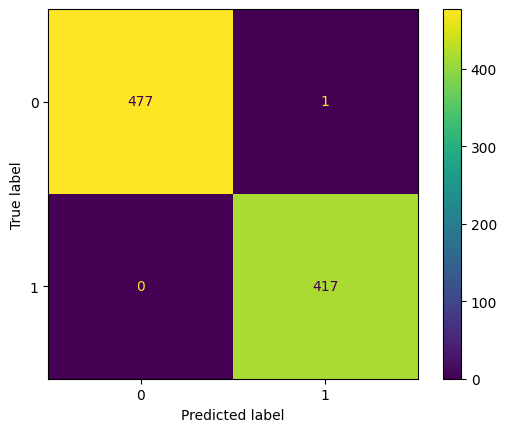

In [67]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, f1_score

# Evaluate the model
print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
print(f'F1: {f1_score(y_test, y_pred):.4f}')
print(f'Precision: {precision_score(y_test, y_pred):.4f}')
print(f'Recall: {recall_score(y_test, y_pred):.4f}')

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm_train = confusion_matrix(y_test, y_pred)
print(cm_train)

cmd_train = ConfusionMatrixDisplay(cm_train)
cmd_train.plot()